In [1]:
import numpy as np
# import json
# import csv
# import collections
import pydash as _
import itertools
from enum import Enum, unique
import time
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import random

## 1. Board movement
General board movement functions and definitions.
The board matrix is framed and padded with `NaN` for easier manipulation of movements without the need to take into account out of bounds indexes.
The location map object maps string indexes to board coordinates. Given that the board has only 6 playable spaces, any possible board configuration can be translated into a single 6 character string.

In [2]:
# Board & Movement constants
BOARD_SIZE = (5,7) # NxN board
BOARD_WIDTH = BOARD_SIZE[0]
BOARD_HEIGHT = BOARD_SIZE[1]

# Empty init to keep variables in global scope
Q = [np.nan]
R = [np.nan]

# LOCATION_MAP = {
#     0: (1,2),
#     1: (2,1),
#     2: (2,2),
#     3: (2,3),
#     4: (3,2),
#     5: (4,2),
#     6: (5,2),
# }
LOCATION_MAP = {
    0: (2,1),
    1: (1,2),
    2: (2,2),
    3: (3,2),
    4: (2,3),
    5: (2,4),
    6: (2,5),
}

@unique
class ACTION(Enum):
    UP = 1
    RIGHT = 2
    DOWN = 3
    LEFT = 4
    STAY = 5

### Board <=> State String transitions 
Calculating and performing movements is easier done with a matrix than an encoded string, thus the project relies on translating state strings into boards back and forth.

In [3]:
def get_empty_board():
    empty_board = np.full(BOARD_SIZE, np.nan)
    for loc_tuple in LOCATION_MAP.values():
        empty_board[loc_tuple] = 0
    return empty_board

print('Empty board: \n{}'.format(get_empty_board()))

def get_board_for_state_string(state_string):
    if(len(state_string) != len(LOCATION_MAP.values())):
        raise ValueError('StateString size if invalid')
    board = np.full(BOARD_SIZE, np.nan) # Start with empty board
    state_tokens = list(state_string)
    for location_idx, value in enumerate(state_tokens):
        location_tuple = LOCATION_MAP[location_idx]
        board[location_tuple] = value
        
    return board

test_input = '1234567'
print('\n\nBoard for state {}: \n{}'.format(test_input, get_board_for_state_string(test_input)))


def get_state_string_for_board(board):
    
    state_tokens = [np.nan]*len(LOCATION_MAP.values())
    for (location_idx, location_tuple) in LOCATION_MAP.items():
        state_tokens[location_idx] = str(int(board[location_tuple]))
    
    state_string = ''.join(state_tokens)
    return state_string


test_input = np.array([[np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                       [np.nan, np.nan,   0.,   np.nan, np.nan, np.nan, np.nan],
                       [np.nan,    1.,    0.,     0.,     0.,     0.,   np.nan],
                       [np.nan, np.nan,   0.,   np.nan, np.nan, np.nan, np.nan],
                       [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]])
print('\n\nState for board: \n{} \n\n{}'.format(test_input, get_state_string_for_board(test_input)))

Empty board: 
[[nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan]
 [nan  0.  0.  0.  0.  0. nan]
 [nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan nan]]


Board for state 1234567: 
[[nan nan nan nan nan nan nan]
 [nan nan  2. nan nan nan nan]
 [nan  1.  3.  5.  6.  7. nan]
 [nan nan  4. nan nan nan nan]
 [nan nan nan nan nan nan nan]]


State for board: 
[[nan nan nan nan nan nan nan]
 [nan nan  0. nan nan nan nan]
 [nan  1.  0.  0.  0.  0. nan]
 [nan nan  0. nan nan nan nan]
 [nan nan nan nan nan nan nan]] 

1000000


## 2. State Transition & Reward

By leveraging the state string to board transformations, we are able to calculate the possible movements for a given agent & execute said moves in a simple maner. Agents are able to move in the cardinal directions to adjacent open spaces. As an alternative, the agent always has the option of staying in place. All combined, there are 5 possible valid movements an agent can make, but depending on its position, only a subset may be available.

In [4]:
# Terminal States manually selected for 1,2 and 3 agent variations
def get_terminal_state(num_agents):
    return   '0000001' if num_agents is 1 \
        else '0000021' if num_agents is 2 \
        else '0000321' if num_agents is 3 \
        else ''
print('Terminal State: {}'.format(get_terminal_state(1)))


def get_random_state(num_agents):
    state = get_terminal_state(num_agents) # Start with terminal state
    state = list(state) # Shuffle requires an array as input
    random.shuffle(state)
    state = ''.join(state) # Back into a single string
    return state

print('Random State: {}'.format(get_random_state(1)))

# Returns all possible states that can be reached given a number of agents in the board
def get_possible_states(num_agents):
    terminal_state = get_terminal_state(num_agents)
    
    possible_states = set(itertools.permutations(terminal_state)) # All UNIQUE permutations
    possible_states = [''.join(state) for state in possible_states] # itertools returns arrays of chars, joining into complete strings
    return possible_states

print('Possible States:\n  {}'.format(get_possible_states(1)))

Terminal State: 0000001
Random State: 0000001
Possible States:
  ['0000010', '0000100', '0001000', '0010000', '0000001', '0100000', '1000000']


In [5]:
# If the destination is not valid (i.e. not an open space), the function returns the current position as next_state

def move_agent(state_string, agent_id, action):
    agent_location = state_string.find(str(agent_id))
    (row, col) = LOCATION_MAP[agent_location]
    board = get_board_for_state_string(state_string)
    if (action == ACTION.UP and board[(row-1,col)] == 0):
        board[(row-1,col)] = agent_id
        board[(row,col)] = 0
        return get_state_string_for_board(board)
    elif (action == ACTION.RIGHT and board[(row,col+1)] == 0):
        board[(row,col+1)] = agent_id
        board[(row,col)] = 0
        return get_state_string_for_board(board)
    elif (action == ACTION.DOWN and board[(row+1,col)] == 0):
        board[(row+1,col)] = agent_id
        board[(row,col)] = 0
        return get_state_string_for_board(board)
    elif (action == ACTION.LEFT and board[(row,col-1)] == 0):
        board[(row,col-1)] = agent_id
        board[(row,col)] = 0
        return get_state_string_for_board(board)
    else: # Either ACTION.STAY or unnable to execute move
        return get_state_string_for_board(board)

print('Move from State: {} + {} => Resulting state: {}'.format('1000000', ACTION.DOWN, move_agent('1000000', 1, ACTION.DOWN)))

def get_available_moves(state_string, agent_id):
    moves = [move_agent(state_string, agent_id, action) for action in ACTION]
    unique_moves = list(set(moves))
    return unique_moves

print('Available destinations from 1000000: {}'.format(get_available_moves('1000000', 1)))

Move from State: 1000000 + ACTION.DOWN => Resulting state: 1000000
Available destinations from 1000000: ['1000000', '0010000']


### Transition Matrix 
The transition matrix maps origin states (rows) into destination states (columns). Thus it is a NxN matrix, N being the number of possible states. Invalid transitions are represented as `NaN` values for a given tuple, while possible transitions are represented as `0`.

Having the default value being `0` also serves a purpose of reutilizing the generated transition matrix as the basis for the R matrix.

In [6]:
# Generates NxN df representing all possible states. All initial values are set to 0. This can be used as the initial Q matrix, as well as the eligibility traces since both matrixes share same structure
def generate_empty_state_matrix(num_agents):
    possible_states = get_possible_states(num_agents)
    
#   Generate NxN Dataframe with all possible states as rows & columns and 0 as values
    df = pd.DataFrame({'state': possible_states,
                        **{state: 0 for state in possible_states}
                       })
    df.set_index('state', inplace=True)
       
    return df
    
generate_empty_state_matrix(num_agents=1)

,0000010,0000100,0001000,0010000,0000001,0100000,1000000
state,,,,,,,
0000010,0,0,0,0,0,0,0
0000100,0,0,0,0,0,0,0
0001000,0,0,0,0,0,0,0
0010000,0,0,0,0,0,0,0
0000001,0,0,0,0,0,0,0
0100000,0,0,0,0,0,0,0
1000000,0,0,0,0,0,0,0


In [7]:
def generate_transition_matrix(agent_id, num_agents):
    if (agent_id > num_agents):
        raise ValueError('Invalid Agent_Id')
    possible_states = get_possible_states(num_agents)
    
#   Generate blank NxN Dataframe with all possible states as rows & columns
    df = pd.DataFrame({'state': possible_states,
                        **{state: np.nan for state in possible_states}
                       })
    df.set_index('state', inplace=True)
    
#   Fill in possible transitions with 0
    for state_string in possible_states:
        available_moves = get_available_moves(state_string, agent_id)
        df.loc[state_string, available_moves] = 0
    
    return df
    
generate_transition_matrix(agent_id=1, num_agents=1)

,0000010,0000100,0001000,0010000,0000001,0100000,1000000
state,,,,,,,
0000010,0.0,0.0,NaN,NaN,0.0,NaN,NaN
0000100,0.0,0.0,NaN,0.0,NaN,NaN,NaN
0001000,NaN,NaN,0.0,0.0,NaN,NaN,NaN
0010000,NaN,0.0,0.0,0.0,NaN,0.0,0.0
0000001,0.0,NaN,NaN,NaN,0.0,NaN,NaN
0100000,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1000000,NaN,NaN,NaN,0.0,NaN,NaN,0.0


## 5 Parameter Setting
The learning parameters are defined below as a globally scoped variable to enable ease of access by the methods lying in multiple layers of abstraction.

In [14]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 10000,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.999,  # Decay if e >= threshold
        'decay_rate_2': 0.99,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

# Helper function to allow for agent id enumeration
def get_agent_ids():
    return range(1, EXPERIMENT['num_agents']+1)

### R-Matrix and reward function
Given that each agent has slightly different transition functions, the reward function also difrs by agent. Although the same general rule applies. Agents are awarded 100 points for any transition that takes them to the desired terminal state, and they are penalized 100 points for any transition that takes them away from it. Any other transition is given no reward.

For generating the R-matrix, the program simply starts with the transition matrix, and fills the relevant transitions with either `-100` or `100` accordingly

In [15]:
def generate_reward_matrix(agent_id, num_agents):
    reward = EXPERIMENT.get('return', 100)
    penalty = EXPERIMENT.get('penalty', -100)
#     Start with Transistion Matrix which already has 0 for all transitions
    reward_matrix = generate_transition_matrix(agent_id, num_agents)
    
#     Set reward at possible transitions to terminal state
    terminal_state = get_terminal_state(num_agents)
    possible_origins = get_available_moves(terminal_state, agent_id) # Destinations & Origins are symmetric
    reward_matrix.loc[terminal_state, possible_origins] = penalty # Moves going out of terminal state are penlized by 100
    reward_matrix.loc[possible_origins, terminal_state] = reward # Moves going into terminal state are rewarded 100
    return reward_matrix

generate_reward_matrix(agent_id=1, num_agents=1)

,0000010,0000100,0001000,0010000,0000001,0100000,1000000
state,,,,,,,
0000010,0.0,0.0,NaN,NaN,100.0,NaN,NaN
0000100,0.0,0.0,NaN,0.0,NaN,NaN,NaN
0001000,NaN,NaN,0.0,0.0,NaN,NaN,NaN
0010000,NaN,0.0,0.0,0.0,NaN,0.0,0.0
0000001,-100.0,NaN,NaN,NaN,100.0,NaN,NaN
0100000,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1000000,NaN,NaN,NaN,0.0,NaN,NaN,0.0


In [63]:
test = generate_transition_matrix(2, 2)
test.to_csv("test.csv")

In [18]:
def initialize_tables(num_agents):
    # Each agent has its own Q and R tables
    Q = {agent_id: generate_transition_matrix(agent_id, num_agents) for agent_id in get_agent_ids()}
    R = {agent_id: generate_reward_matrix(agent_id, num_agents) for agent_id in get_agent_ids()}
    return (Q, R)
    
(Q, R) = initialize_tables(1)

## Epsilon update policy
The ε-greedy policy determines that the agent is to explore (i.e. take a random action) with ε probability, and exploit (i.e. take the action which has the highest expected return as per the Q-matrix) with (1-ε) probability. A strategy for gradual refinement is to have a gradually decreasing ε value. This means that when there is more uncertainty (i.e. at the beginning of the experiment, when not much is known regarding the environment), the agent takes action randomly to gather feedback and "understanding" of the surrounding environment. Gradually, the more the agent knows regarding the environment,less often it takes random actions. This effectively has the result of directing the random exploration to regions surrounding the current action policy.

In [20]:
def choose_next_state(current_state, current_agent_id, epsilon):    
    # exploit
    if (random.random() >= epsilon):
        current_q = Q[current_agent_id] # Get current agent's Q-matrix
        max_expected_rewards = current_q.idxmax(axis=1) # Column index for max value in each row
        return max_expected_rewards[current_state]
        
    # explore
    else:
        possible_moves = get_available_moves(current_state, current_agent_id)
        return random.choice(possible_moves)


In [21]:
def update_epsilon(epsilon):
    if (epsilon >= EXPERIMENT['epsilon']['decay_rate_threshold']):
        decay_rate = EXPERIMENT['epsilon']['decay_rate_1']
    else:
        decay_rate = EXPERIMENT['epsilon']['decay_rate_2']
    return epsilon * decay_rate

## Q-Matrix update


After each step, the Q matrix is updated according to the earned return and current Q-Matrix according to the following formula
$$Q(s_{t},a_{t}) = Q(s_{t},a_{t}) + α*[r_{t+1}+γ*max_{a} Q(s_{t+1},a_{t+1}) - Q(s_{t},a_{t})]$$
$$Q(s,a) = Q(s,a) + α*[r+γ*max_{a'} Q(s',a') - Q(s,a)]$$

In [23]:
# Returns the RETURN in table R associated with transitioning from current to next state
def calculate_earned_reward(current_state, next_state, current_agent_id):
    current_r = R[current_agent_id] # Get current agent's R-matrix
    earned_reward = current_r.loc[current_state, next_state]
    return earned_reward

def update_q_matrix(current_state, next_state, current_agent_id, earned_reward):
    # Get alpha and gamma from experiment settings
    alpha = EXPERIMENT['alpha']
    gamma = EXPERIMENT['gamma']

    # Get current agent's Q-matrix
    current_q = Q[current_agent_id]

    # Q(s,a)old
    old_expected_return = current_q.loc[current_state, next_state]

    # max a' Q(s',a')
    possible_next_moves = get_available_moves(next_state, current_agent_id)
    best_expected_return = max(current_q.loc[next_state, possible_next_moves])

    # Q(s,a)new
    new_expected_return = old_expected_return + alpha * (earned_reward + gamma * best_expected_return - old_expected_return)

    # Update value in current agent's Q-matrix
    current_q.loc[current_state, next_state] = new_expected_return
    
    change_difference = abs(new_expected_return-old_expected_return)
    return change_difference
    
    
    

## 6 Learning Episode
Each learning episode starts with a random state. Agents then take turns performing actions, observeing the punishment/reward given by their respective R-Matrix and updating their respective Q-Matrix accordingly.

An episode ends when either a predefined number of steps are taken(configurable in the experiment parameters), or the terminal state is reached. One detail that is important to stress is that the terminal state is only considered as reached when every single agent has perfomed an action that results in reaching that state, thus collecting its reward.

In [24]:
def run_episode(epsilon):
    # Episode starting values    
    num_agents = EXPERIMENT['num_agents']
    total_reward = 0 
    agent_reward = {agent_id: 0 for agent_id in get_agent_ids()}
    current_state = get_random_state(num_agents)
    state_history = [current_state]
    did_episode_update = {agent_id: 0 for agent_id in get_agent_ids()}
    
    while(not did_finish_episode(state_history)):
        current_agent_id = (len(state_history) % num_agents) + 1 # agent_ids start at 1. Agents take turns performing actions
        next_state = choose_next_state(current_state, current_agent_id, epsilon)
        
        earned_reward = calculate_earned_reward(current_state, next_state, current_agent_id) # Determine return from R matrix for the agent taking action
        change_difference = update_q_matrix(current_state, next_state, current_agent_id, earned_reward) # Update Q Matrix for the agent taking action
        
        if(change_difference != 0):
            did_episode_update[current_agent_id] += 1
        
        # Update values for next loop pass
        state_history.append(next_state)
        current_state = next_state
        agent_reward[current_agent_id] += earned_reward
        total_reward += earned_reward
        
    did_reach_terminal = state_history[-1] == get_terminal_state(num_agents)
    
    return ({
        'epsilon': epsilon,
        'total_steps':len(state_history), 
        **{('reward_'+str(agent_id)): agent_reward[agent_id] for agent_id in get_agent_ids()},
        'reward_total':total_reward,
        'final_state': current_state, 
        'did_reach_terminal':did_reach_terminal,
        **{('did_update_q_'+str(agent_id)): did_episode_update[agent_id] for agent_id in get_agent_ids()},        
    })

def did_finish_episode(state_history):
    current_step = len(state_history)
    terminal_state = get_terminal_state(EXPERIMENT['num_agents'])
    recent_history = state_history[-EXPERIMENT['num_agents']:]     # Ensures terminal state is reached only after ALL agents took one action after reaching it & gained their reward
    
    if (current_step > 1 and all(state == terminal_state for state in recent_history)):
        return True
    elif (current_step > EXPERIMENT['max_steps']): # Agent timeout. Finish episode by exhaustion
        return True
    else:
        return False

run_episode(0.5)

{'epsilon': 0.5,
 'total_steps': 8,
 'reward_1': 100.0,
 'reward_total': 100.0,
 'final_state': '0000001',
 'did_reach_terminal': True,
 'did_update_q_1': 1}

### Experiment

An experiment is defined as a collection of learning episodes while using a defined set of parameters. After each learning episode, it's results are stored for later analysis, and the epsilon value is updated according to the epsilon greedy policy

In [25]:
# Main Loop

# Empty init to keep variables in global scope
Q = np.nan
R = np.nan

def perform_experiment():
    global Q
    global R
    (Q, R) = initialize_tables(EXPERIMENT['num_agents'])
    
    epsilon = EXPERIMENT['epsilon']['initial_value']
    results = []
    
    for current_episode in range(EXPERIMENT['num_episodes']):
        episode_result = run_episode(epsilon)
        results.append({'episode': current_episode, **episode_result})
        epsilon = update_epsilon(epsilon)

        # Progress report
        if (current_episode%(EXPERIMENT['num_episodes']/10) == 0):
            progress = current_episode/EXPERIMENT['num_episodes']
            progress_string = '{:02d}%  '.format(int(progress*100))
            print(progress_string, end='')
    print('100%')
    return results

# perform_experiment()

In [50]:
ROLLING_WINDOW=100

COLOR = [
    '#1b9e77',
    '#d95f02',
    '#7570b3',
    '#e7298a',
    '#66a61e',
    '#e6ab02',
    '#a6761d',
    '#666666',
]

def show_results(experiment_results):
    df = process_results(experiment_results)
    
    #     Figure 1: Win % (rolling) and Epsilon vs Learning Episode
    plot_win_vs_epsilon(df, 1)
    #     Figure 2: Steps vs Episode
    plot_total_steps_rolling(df, 2)
    #     Figure 3: Q Update vs Episode
    plot_did_change_q(df, 3)
    

    
def process_results(experiment_results):
    df = pd.DataFrame.from_records(experiment_results)
    for agent_id in get_agent_ids():
        agent_id = str(agent_id)
        df['rwd_'+agent_id] = df['reward_'+agent_id]/df['total_steps']
    df['rwd_tot'] = df['reward_total']/df['total_steps']
#     df['cumulative win %'] = df['did_reach_terminal'].cumsum()/(df['episode']+1)
#     s.rolling(3).sum()
    
    return df

def get_episode_epsilon_change(df):
    decay_threshold = EXPERIMENT['epsilon']['decay_rate_threshold']
    episode = df[df.epsilon >= decay_threshold].head(1).episode.values[0]
    return episode


EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 1000,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.999,  # Decay if e >= threshold
        'decay_rate_2': 0.99,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}
# test_input = perform_experiment()
# show_results(test_input)
# show_results(results)

In [28]:
def plot_win_vs_epsilon(df, figure_num=1):
    plt.figure(figure_num); 
    x = df['episode']
    y1 = df['did_reach_terminal'].rolling(ROLLING_WINDOW).sum()/ROLLING_WINDOW
    y2 = df['epsilon']
    

    fig, ax1 = plt.subplots()
    
    ax_color_1 = COLOR[5]
    ax_color_2 = COLOR[0]

    ax2 = ax1.twinx()
    ax1.plot(x, y1, color=ax_color_1)
    ax2.plot(x, y2, color=ax_color_2)

    ax1.set_xlabel('Episodes', fontsize=12)
    ax1.set_ylabel('Win % Rolling Average ({})'.format(ROLLING_WINDOW), color=ax_color_1, fontsize=12)
    ax2.set_ylabel('Epsilon', color=ax_color_2, fontsize=12)
    plt.title('Win % Rolling Average ({}) x Episodes'.format(ROLLING_WINDOW), fontsize=14)
    
    # Vertical Line where Epsilon Decay Changes
    ax1.axvline(x=get_episode_epsilon_change(df), linestyle='--', linewidth=1, color='gray')

    plt.show()

# plot_win_vs_epsilon(process_results(results))

In [29]:
def plot_total_steps_rolling(df, figure_num=1):
    plt.figure(figure_num); 
    x = df['episode']
    y1 = df['total_steps'].rolling(ROLLING_WINDOW).mean()
    y2 = df['epsilon']

    fig, ax1 = plt.subplots()
    
    ax_color_1 = COLOR[3]
    ax_color_2 = COLOR[0]

    ax2 = ax1.twinx()
    ax1.plot(x, y1, color=ax_color_1)
    ax2.plot(x, y2, color=ax_color_2)

    ax1.set_xlabel('Episodes', fontsize=12)
    ax1.set_ylabel('Total Steps - Rolling Average ({})'.format(ROLLING_WINDOW), color=ax_color_1, fontsize=12)
    ax2.set_ylabel('Epsilon', color=ax_color_2, fontsize=12)
    plt.title('Total Steps - Rolling Average ({}) x Episodes'.format(ROLLING_WINDOW), fontsize=14)

    # Vertical Line where Epsilon Decay Changes
    ax1.axvline(x=get_episode_epsilon_change(df), linestyle='--', linewidth=1, color='gray')
    
    plt.show()
    
# plot_total_steps_rolling(process_results(results))

In [30]:
def plot_did_change_q(df, figure_num=1):
    plt.figure(figure_num); 
    x = df['episode']
#     y1 = (df['did_update_q']/df['total_steps']).rolling(ROLLING_WINDOW).mean()
#     y1 = (df['did_update_q']/df['total_steps']).rolling(ROLLING_WINDOW).mean()
#     y1 = (df['did_update_q']/df['total_steps']).rolling(ROLLING_WINDOW).mean()
    y2 = df['epsilon']

    fig, ax1 = plt.subplots()
    
#     ax_color_1 = COLOR[4]
    ax_color_2 = COLOR[0]

    ax2 = ax1.twinx()
    agent_labels =[]
    for agent_id in get_agent_ids():
        color = COLOR[agent_id]
        agent_id = str(agent_id)
        agent_labels.append('Agent {}'.format(agent_id))
        y = (df['did_update_q_'+agent_id]/df['total_steps']).rolling(ROLLING_WINDOW).mean()
        ax1.plot(x, y, color=color)
    ax1.legend(agent_labels)
    ax2.plot(x, y2, color=ax_color_2)

    ax1.set_xlabel('Episodes', fontsize=12)
    ax1.set_ylabel('Q Updates/Steps'.format(ROLLING_WINDOW), fontsize=12)
    ax2.set_ylabel('Epsilon', color=ax_color_2, fontsize=12)
    plt.title('Q Updates per Step - Rolling Average ({}) x Episodes'.format(ROLLING_WINDOW), fontsize=14)

    # Vertical Line where Epsilon Decay Changes
    ax1.axvline(x=get_episode_epsilon_change(df), linestyle='--', linewidth=1, color='gray')
    
    plt.show()

# plot_did_change_q(process_results(results))

## Plot Results for multiple experiments with varying params

In [33]:
def show_results_multi(all_results, labels):    
    #     Figure 1: Win % (rolling) and Epsilon vs Learning Episode
    plot_win_vs_epsilon_multi(all_results, labels, 1)
    #     Figure 2: Steps vs Episode
    plot_total_steps_multi(all_results, labels, 2)
    #     Figure 3: Q Update vs Episode
    plot_did_change_q_multi(all_results, labels, 3)

# show_results_multi(epsilon_results, epsilon_to_test)

In [34]:
def plot_win_vs_epsilon_multi(all_dfs, labels, figure_num=1):
    plt.figure(figure_num); 
    x = all_dfs[0]['episode']
    
    for index, df in enumerate(all_dfs):
        y = df['did_reach_terminal'].rolling(ROLLING_WINDOW).sum()/ROLLING_WINDOW
        plt.plot(x, y, color=COLOR[index])
    plt.legend(labels)
    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('Win % Rolling Average ({})'.format(ROLLING_WINDOW), fontsize=12)
    plt.title('Win % Rolling Average ({}) x Episodes'.format(ROLLING_WINDOW), fontsize=14)

    plt.show()

# plot_win_vs_epsilon_multi(epsilon_results, epsilon_to_test)

In [35]:
def plot_total_steps_multi(all_dfs, labels, figure_num=1):
    plt.figure(figure_num); 
    x = all_dfs[0]['episode']
    
    for index, df in enumerate(all_dfs):
        y = df['total_steps'].rolling(ROLLING_WINDOW).mean()
        plt.plot(x, y, color=COLOR[index])
    plt.legend(labels)
    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('Total Steps - Rolling Average ({})'.format(ROLLING_WINDOW), fontsize=12)
    plt.title('Total Steps - Rolling Average ({}) x Episodes'.format(ROLLING_WINDOW), fontsize=14)
    
    plt.show()
    
# plot_total_steps_multi(epsilon_results, epsilon_to_test)

In [36]:
def plot_did_change_q_multi(all_dfs, labels, figure_num=1):
    plt.figure(figure_num); 
    x = all_dfs[0]['episode']
    
    linestyles = {'1':'-', '2':':', '3':'--'}
    
    agent_labels =[]
    for index, df in enumerate(all_dfs):
        for agent_id in get_agent_ids():
            color = COLOR[agent_id]
            agent_id = str(agent_id)
            agent_labels.append('{}-{}'.format(agent_id, labels[index]))
            y = (df['did_update_q_'+agent_id]/df['total_steps']).rolling(ROLLING_WINDOW).mean()
            plt.plot(x, y, color=COLOR[index], ls=linestyles[agent_id])

#     plt.legend(labels)

    
    plt.legend(agent_labels)
    plt.xlabel('Episodes', fontsize=12)
    plt.ylabel('Q Updates/Steps'.format(ROLLING_WINDOW), fontsize=12)
    plt.title('Q Updates per Step - Rolling Average ({}) x Episodes'.format(ROLLING_WINDOW), fontsize=14)
    
    plt.show()

# plot_did_change_q_multi(all_results, alphas_to_test)

### EXP 1.1: 1 Agent

00%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%


<Figure size 432x288 with 0 Axes>

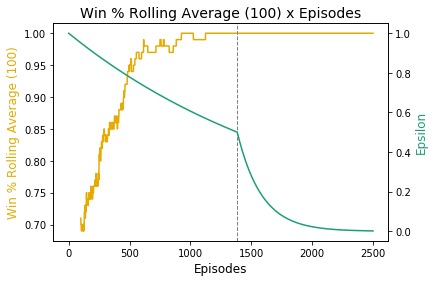

<Figure size 432x288 with 0 Axes>

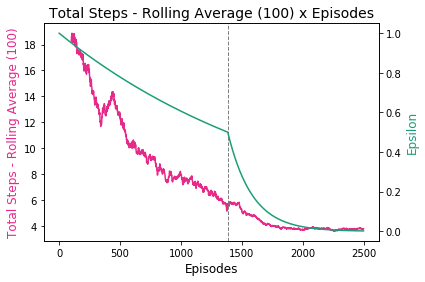

<Figure size 432x288 with 0 Axes>

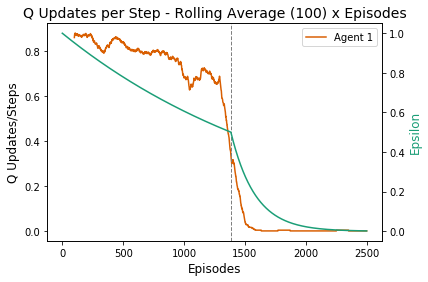

In [31]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 2500,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}
results = perform_experiment()
show_results(results)

### EXP 1.2: 2 Agents

In [ ]:
EXPERIMENT = {
    'num_agents': 2,        # ∈ {1,2,3}
    'num_episodes': 2500,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}
results = perform_experiment()
show_results(results)

## EXP 3 - Alpha

In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 2500,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.8, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

alpha_results = []
alphas_to_test = [a/10 for a in range(0, 11, 2)]
for alpha in alphas_to_test:
    EXPERIMENT['alpha'] = alpha
    print('alpha={} - '.format(alpha), end='')
    instance_results = perform_experiment()
    alpha_results.append(process_results(instance_results))

show_results_multi(alpha_results, alphas_to_test)

## EXP 4 - Gamma


In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 2500,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.8, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

gamma_results = []
gammas_to_test = [g/10 for g in range(1, 10, 2)]
for gamma in gammas_to_test:
    EXPERIMENT['gamma'] = gamma
    print('gamma={} - '.format(gamma), end='')
    instance_results = perform_experiment()
    gamma_results.append(process_results(instance_results))

show_results_multi(gamma_results, gammas_to_test)

### EXP 5 - Episode Duration (MaxSteps)

In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 3000,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.8, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

max_steps_results = []
max_steps_to_test = [4, 6, 8, 10, 30, 60, 100]
for max_steps in max_steps_to_test:
    EXPERIMENT['max_steps'] = max_steps
    print('max_steps={} - '.format(max_steps), end='')
    instance_results = perform_experiment()
    max_steps_results.append(process_results(instance_results))

show_results_multi(max_steps_results, max_steps_to_test)

EXPERIMENT['epsilon'] = {
        'initial_value': 1,
        'decay_rate_1': 1,  # Decay if e >= threshold
        'decay_rate_2': 1,   # Decay if e < threshold
        'decay_rate_threshold': 0,
    }

max_steps_random_results = []
for max_steps in max_steps_to_test:
    EXPERIMENT['max_steps'] = max_steps
    print('max_steps={} - '.format(max_steps), end='')
    instance_results = perform_experiment()
    max_steps_random_results.append(process_results(instance_results))

show_results_multi(max_steps_random_results, max_steps_to_test)

### Exp 6 - Epsilon

### Exp 6.1 - Initial Epsilon


In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 400,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.8, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

epsilon_results = []

epsilon_to_test = [0, 0.2, 0.5, 0.9, 0.999, 1]
for epsilon in epsilon_to_test:
    EXPERIMENT['epsilon']['initial_value'] = epsilon
    print('initial_value={} - '.format(epsilon), end='')
    instance_results = perform_experiment()
    epsilon_results.append(process_results(instance_results))

show_results_multi(epsilon_results, epsilon_to_test)

### Exp 6.2 - Epsilon Threshold

In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 400,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.8, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

epsilon_results = []
epsilon_to_test = [0.9, 0.95, 0.99, 0.995, 0.997, 0.998]
for epsilon in epsilon_to_test:
    EXPERIMENT['epsilon']['decay_rate_threshold'] = epsilon
    print('decay_rate_threshold={} - '.format(epsilon), end='')
    instance_results = perform_experiment()
    epsilon_results.append(process_results(instance_results))

show_results_multi(epsilon_results, epsilon_to_test)

## 6.3 Decay Rate

In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 2500,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.8, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
}

epsilon_results = []

epsilon_to_test = [(0.99995, 0.9995), (0.995, 0.95), (0.99, 0.9), (0.9, 0.8), (0.79,0.7), (0.59,0.5) ]
for epsilon in epsilon_to_test:
    EXPERIMENT['epsilon']['decay_rate_1'] = epsilon[0]
    EXPERIMENT['epsilon']['decay_rate_2'] = epsilon[1]
    print('decay rate={}-{} - '.format(epsilon[0], epsilon[1]), end='')
    instance_results = perform_experiment()
    epsilon_results.append(process_results(instance_results))

show_results_multi(epsilon_results, epsilon_to_test)

In [ ]:
perform_experiment()

## TD(lambda) Learning with eligibility traces

In [ ]:
# import copy

In [38]:
# Eligibility Traces - TD(lambda)
def update_q_matrix_td(current_state, next_state, current_agent_id, earned_reward):
#     global Q
#     global E
    # Get alpha and gamma from experiment settings
    alpha = EXPERIMENT['alpha']
    gamma = EXPERIMENT['gamma']
    lamb = EXPERIMENT['lambda']
    
    eligibility = E[current_agent_id]

    # Get current agent's Q-matrix
    current_q = Q[current_agent_id]

    # Q(s,a)old
    old_expected_return = current_q.loc[current_state, next_state]
    
    # max a' Q(s',a')
    possible_next_moves = get_available_moves(next_state, current_agent_id)
    best_expected_return = max(current_q.loc[next_state, possible_next_moves])
    
    # δ
    delta = earned_reward + (gamma * best_expected_return) - old_expected_return
    
    # Decay Eligibility & update current trace
    eligibility = eligibility*gamma*lamb
    eligibility.loc[current_state, next_state] = 1 # Replacing Traces technique
    E[current_agent_id] = eligibility
    
    Q[current_agent_id] = current_q + (alpha * delta * eligibility)
#     Q[current_agent_id] = current_q


# EXPERIMENT['num_agents'] = 1
# (Q, R) = initialize_tables(1)
# E = {agent_id: generate_empty_state_matrix(1) for agent_id in get_agent_ids()}
# update_q_matrix_td("0001000", "0000010", 1, 0)



In [48]:
import copy
# TD Learning
def run_episode_td(epsilon):
    # Episode starting values
    num_agents = EXPERIMENT['num_agents']
    total_reward = 0 
    agent_reward = {agent_id: 0 for agent_id in get_agent_ids()}
    current_state = get_random_state(num_agents)
    state_history = [current_state]
#     transition_history = {agent_id: [] for agent_id in get_agent_ids()} # Separate transition history for each agent
    did_episode_update = {agent_id: 0 for agent_id in get_agent_ids()}
    global E
    E = {agent_id: generate_empty_state_matrix(num_agents) for agent_id in get_agent_ids()}
    
    while(not did_finish_episode(state_history)):
        current_agent_id = (len(state_history) % num_agents) + 1 # agent_ids start at 1. Agents take turns performing actions
        next_state = choose_next_state(current_state, current_agent_id, epsilon)
        
        earned_reward = calculate_earned_reward(current_state, next_state, current_agent_id) # Determine return from R matrix for the agent taking action
        old_Q = copy.deepcopy(Q)
        update_q_matrix_td(current_state, next_state, current_agent_id, earned_reward) # Update Q Matrix for the agent taking action
        if (not Q[current_agent_id].equals(old_Q)):
            did_episode_update[current_agent_id] += 1
#         did_episode_update[current_agent_id] += 1
        
        # Update values for next loop pass
        state_history.append(next_state)
        current_state = next_state
        agent_reward[current_agent_id] += earned_reward
        total_reward += earned_reward
        
    did_reach_terminal = state_history[-1] == get_terminal_state(num_agents)
    
    return ({
        'epsilon': epsilon,
        'total_steps':len(state_history), 
        **{('reward_'+str(agent_id)): agent_reward[agent_id] for agent_id in get_agent_ids()},
        'reward_total':total_reward,
        'final_state': current_state, 
        'did_reach_terminal':did_reach_terminal,
        **{('did_update_q_'+str(agent_id)): did_episode_update[agent_id] for agent_id in get_agent_ids()}, 
    })


# EXPERIMENT = {
#     'num_agents': 2,        # ∈ {1,2,3}
#     'num_episodes': 5000,    # Number of episodes the experiment lasts
#     'max_steps': 50,       # Max steps per episode
#     'epsilon': {
#         'initial_value': 0.999,
#         'decay_rate_1': 0.9995,  # Decay if e >= threshold
#         'decay_rate_2': 0.995,   # Decay if e < threshold
#         'decay_rate_threshold': 0.5,
#     },
#     'alpha': 0.5, # learning rate
#     'gamma': 0.5, # dicount factor
#     'return': 100, # Return for moving into terminal state
#     'penalty': -100, # Punishment for leaving terminal state
#     'lambda': 0.2, # Lambda in TD(lambda) eligibility traces
# }

# run_episode_td(0.5)

In [39]:
# Main Loop

# Empty init to keep variables in global scope
Q = np.nan
R = np.nan

def perform_experiment_td():
    global Q
    global R
    (Q, R) = initialize_tables(EXPERIMENT['num_agents'])
    
    epsilon = EXPERIMENT['epsilon']['initial_value']
    results = []
    
    for current_episode in range(EXPERIMENT['num_episodes']):
        episode_result = run_episode_td(epsilon)
        results.append({'episode': current_episode, **episode_result})
        epsilon = update_epsilon(epsilon)

        # Progress report
        if (current_episode%(EXPERIMENT['num_episodes']/10) == 0):
            progress = current_episode/EXPERIMENT['num_episodes']
            progress_string = '{:02d}%  '.format(int(progress*100))
            print(progress_string, end='')
    print('100%')
    return results

# perform_experiment_td()

In [ ]:
# EXPERIMENT = {
#     'num_agents': 1,        # ∈ {1,2,3}
#     'num_episodes': 5000,    # Number of episodes the experiment lasts
#     'max_steps': 30,       # Max steps per episode
#     'epsilon': {
#         'initial_value': 0.999,
#         'decay_rate_1': 0.9995,  # Decay if e >= threshold
#         'decay_rate_2': 0.995,   # Decay if e < threshold
#         'decay_rate_threshold': 0.5,
#     },
#     'alpha': 0.5, # learning rate
#     'gamma': 0.5, # dicount factor
#     'return': 100, # Return for moving into terminal state
#     'penalty': -100, # Punishment for leaving terminal state
#     'lambda': 0.2, # Lambda in TD(lambda) eligibility traces
# }

# (Q, R) = initialize_tables(2)
# E = {agent_id: generate_empty_state_matrix(1) for agent_id in get_agent_ids()}

# run_episode_td(0.9)
# print("------------------\nQ")
# print(Q)
# print("------------------\nE")
# print(E)

# print("\n\n\n")

In [59]:
(Q, R) = initialize_tables(2)
E = {agent_id: generate_empty_state_matrix(2) for agent_id in get_agent_ids()}

update_q_matrix_td("0002100", "0002010", 1, 0)
print("------------------\nQ")
print(Q[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])
print("------------------\nE")
print(E[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])

print("\n\n\n")

------------------
Q
         0002100  0002010  0002001  0000210  0000201  0000021
state                                                        
0002100      0.0      0.0      NaN      NaN      NaN      NaN
0002010      0.0      0.0      0.0      NaN      NaN      NaN
0002001      NaN      0.0      0.0      NaN      NaN      NaN
0000210      NaN      NaN      NaN      0.0      0.0      NaN
0000201      NaN      NaN      NaN      0.0      0.0      NaN
0000021      NaN      NaN      NaN      NaN      NaN      0.0
------------------
E
         0002100  0002010  0002001  0000210  0000201  0000021
state                                                        
0002100      0.0      1.0      0.0      0.0      0.0      0.0
0002010      0.0      0.0      0.0      0.0      0.0      0.0
0002001      0.0      0.0      0.0      0.0      0.0      0.0
0000210      0.0      0.0      0.0      0.0      0.0      0.0
0000201      0.0      0.0      0.0      0.0      0.0      0.0
0000021      0.0      0.0   

In [62]:
print(Q[2].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])

         0002100  0002010  0002001  0000210  0000201  0000021
state                                                        
0002100      NaN      NaN      NaN      NaN      NaN      NaN
0002010      NaN      NaN      NaN      NaN      NaN      NaN
0002001      NaN      NaN      NaN      NaN      NaN      NaN
0000210      NaN      NaN      NaN      NaN      NaN      NaN
0000201      NaN      NaN      NaN      NaN      NaN      NaN
0000021      NaN      NaN      NaN      NaN      NaN      NaN


In [60]:
update_q_matrix_td("0002010", "0000210", 2, 0)
print("------------------\nQ")
print(Q[2].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])
print("------------------\nE")
print(E[2].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])

print("\n\n\n")

------------------
Q
         0002100  0002010  0002001  0000210  0000201  0000021
state                                                        
0002100      NaN      NaN      NaN      NaN      NaN      NaN
0002010      NaN      NaN      NaN      NaN      NaN      NaN
0002001      NaN      NaN      NaN      NaN      NaN      NaN
0000210      NaN      NaN      NaN      NaN      NaN      NaN
0000201      NaN      NaN      NaN      NaN      NaN      NaN
0000021      NaN      NaN      NaN      NaN      NaN      NaN
------------------
E
         0002100  0002010  0002001  0000210  0000201  0000021
state                                                        
0002100      0.0      0.0      0.0      0.0      0.0      0.0
0002010      0.0      0.0      0.0      1.0      0.0      0.0
0002001      0.0      0.0      0.0      0.0      0.0      0.0
0000210      0.0      0.0      0.0      0.0      0.0      0.0
0000201      0.0      0.0      0.0      0.0      0.0      0.0
0000021      0.0      0.0   

In [ ]:
update_q_matrix_td("0000210", "0000201", 1, 0)
print("------------------\nQ")
print(Q[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])
print("------------------\nE")
print(E[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])

print("\n\n\n")

In [ ]:
update_q_matrix_td("0000201", "0000021", 2, 200)
print("------------------\nQ")
print(Q[2].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])
print("------------------\nE")
print(E[2].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])

print("\n\n\n")

In [ ]:
update_q_matrix_td("0000021", "0000021", 1, 200)
print("------------------\nQ")
print(Q[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])
print("------------------\nE")
print(E[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]])

print("\n\n\n")

In [ ]:
EXPERIMENT = {
    'num_agents': 1,        # ∈ {1,2,3}
    'num_episodes': 5000,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
    'lambda': 0.2, # Lambda in TD(lambda) eligibility traces
}

lambda_results = []

lambda_to_test = [0.1, 0.3, 0.5, 0.7, 0.9]
for lamb in lambda_to_test:
    EXPERIMENT['lambda'] = lamb

    print('Lambda={} - '.format(lamb), end='')
    instance_results = perform_experiment_td()
    lambda_results.append(process_results(instance_results))

show_results_multi(lambda_results, lambda_to_test)

In [ ]:
EXPERIMENT = {
    'num_agents': 2,        # ∈ {1,2,3}
    'num_episodes': 5000,    # Number of episodes the experiment lasts
    'max_steps': 30,       # Max steps per episode
    'epsilon': {
        'initial_value': 0.999,
        'decay_rate_1': 0.9995,  # Decay if e >= threshold
        'decay_rate_2': 0.995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.5, # dicount factor
    'return': 100, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
    'lambda': 0.2, # Lambda in TD(lambda) eligibility traces
}

lambda_results = []

lambda_to_test = [0.1, 0.3, 0.5, 0.7, 0.9]
for lamb in lambda_to_test:
    EXPERIMENT['lambda'] = lamb

    print('Lambda={} - '.format(lamb), end='')
    instance_results = perform_experiment_td()
    lambda_results.append(process_results(instance_results))

show_results_multi(lambda_results, lambda_to_test)

00%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%


<Figure size 432x288 with 0 Axes>

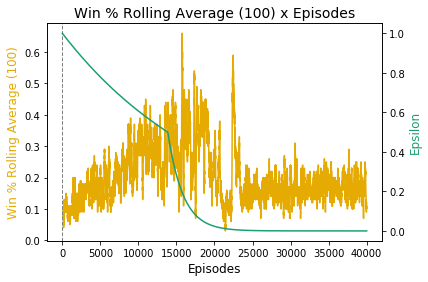

<Figure size 432x288 with 0 Axes>

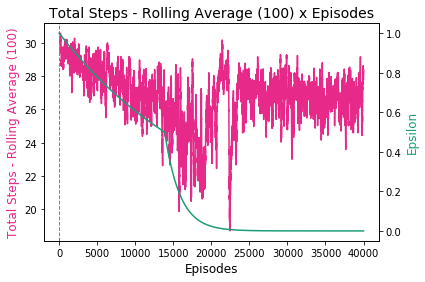

<Figure size 432x288 with 0 Axes>

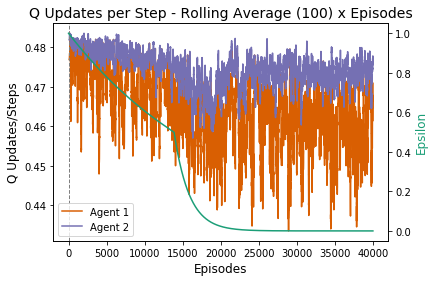

In [52]:
EXPERIMENT = {
    'num_agents': 2,        # ∈ {1,2,3}
    'num_episodes': 40000,  # Number of episodes the experiment lasts
    'max_steps': 30,        # Max steps per episode
    'epsilon': {
        'initial_value': 0.99999,
        'decay_rate_1': 0.99995,  # Decay if e >= threshold
        'decay_rate_2': 0.9995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.9, # dicount factor
    'return': 2000, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
    'lambda': 0.6,
}
results = perform_experiment_td()
show_results(results)

00%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%


<Figure size 432x288 with 0 Axes>

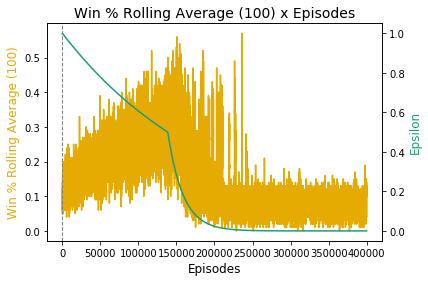

<Figure size 432x288 with 0 Axes>

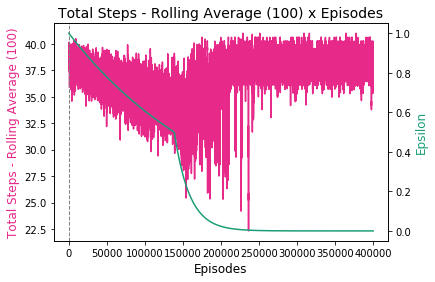

<Figure size 432x288 with 0 Axes>

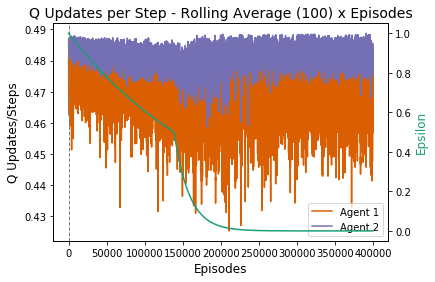

In [54]:
EXPERIMENT = {
    'num_agents': 2,        # ∈ {1,2,3}
    'num_episodes': 400000,  # Number of episodes the experiment lasts
    'max_steps': 40,        # Max steps per episode
    'epsilon': {
        'initial_value': 0.999999,
        'decay_rate_1': 0.999995,  # Decay if e >= threshold
        'decay_rate_2': 0.99995,   # Decay if e < threshold
        'decay_rate_threshold': 0.5,
    },
    'alpha': 0.5, # learning rate
    'gamma': 0.9, # dicount factor
    'return': 200, # Return for moving into terminal state
    'penalty': -100, # Punishment for leaving terminal state
    'lambda': 0.99,
}
results_2 = perform_experiment_td()
show_results(results_2)

In [55]:
Q[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]]

,0002100,0002010,0002001,0000210,0000201,0000021
state,,,,,,
0002100,1.167745e-15,1.210806e-15,NaN,NaN,NaN,NaN
0002010,-6.737689e-14,-7.141374e-15,1.345340e-15,NaN,NaN,NaN
0002001,NaN,1.449565e-15,-1.015714e-13,NaN,NaN,NaN
0000210,NaN,NaN,NaN,1.738167e-12,2.024644e-12,NaN
0000201,NaN,NaN,NaN,1.816379e-12,2.025899e-12,NaN
0000021,NaN,NaN,NaN,NaN,NaN,2000.0


In [ ]:
# E[1].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]]

In [58]:
R[2].loc[["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"], ["0002100", "0002010", "0002001", "0000210", "0000201", "0000021"]]

,0002100,0002010,0002001,0000210,0000201,0000021
state,,,,,,
0002100,0.0,NaN,NaN,NaN,NaN,NaN
0002010,NaN,0.0,NaN,NaN,NaN,NaN
0002001,NaN,NaN,0.0,NaN,NaN,NaN
0000210,NaN,NaN,NaN,0.0,NaN,NaN
0000201,NaN,NaN,NaN,NaN,0.0,200.0
0000021,NaN,NaN,NaN,NaN,-100.0,200.0
